In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from cmcrameri.cm import *
import numpy as np
import os
import netCDF4 as nc

In [2]:
R_earth = 6.371e6
M_earth = 5.972e24
bar = 1e5 # Pa

In [21]:
# scale factor, log axis, unit name
units = {
    # input vars
    "frac_core"     : [100,       False  ,"mass%"],
    "frac_atm"      : [100,       False  ,"mass%"],
    "mass_tot"      : [1.0,       False  ,r"M$_\oplus$"],

    # output vars
    "p_surf"        : [1e-5,      True   ,"bar"], # output, Pa -> bar
    "t_surf"        : [1,         False  ,"K"],
    "r_surf"        : [1/R_earth, False  ,r"R$_\oplus$"],
    "μ_surf"        : [1e3,       False  ,"g/mol"],

    "r_phot"        : [1/R_earth, False  ,r"R$_\oplus$"],
    "μ_phot"        : [1e3,       False  ,"g/mol"],
    "t_phot"        : [1,         False  ,"K"],
    "Kzz_max"       : [1e4,       True   ,"cm2/s"],

}


In [22]:
# Read both of the CSV files
output_dir = "../out"
gridpoints_df = pd.read_csv(os.path.join(output_dir, "gridpoints.csv"), sep=',')
results_df = pd.read_csv(os.path.join(output_dir, "result_table.csv"), sep=',')

# Merge the dataframes on index
data = pd.merge(gridpoints_df, results_df, on="index")

gridsize = len(data)
print(gridsize)

# Define input and output variables
input_vars  = list(gridpoints_df.keys())
output_vars = list(results_df.keys())

input_vars.remove("index")
output_vars.remove("index")

8


In [23]:
# Read NetCDF output file
ds = nc.Dataset(os.path.join(output_dir,"result_profs.nc"))

data_t = np.array(ds["t"][:,:], copy=True, dtype=float)
data_p = np.array(ds["p"][:,:], copy=True, dtype=float)
data_r = np.array(ds["r"][:,:], copy=True, dtype=float)

ds.close()


/tmp/user/27339/ipykernel_782103/1498000237.py:45: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yticklabels([])
/tmp/user/27339/ipykernel_782103/1498000237.py:53: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.tight_layout()


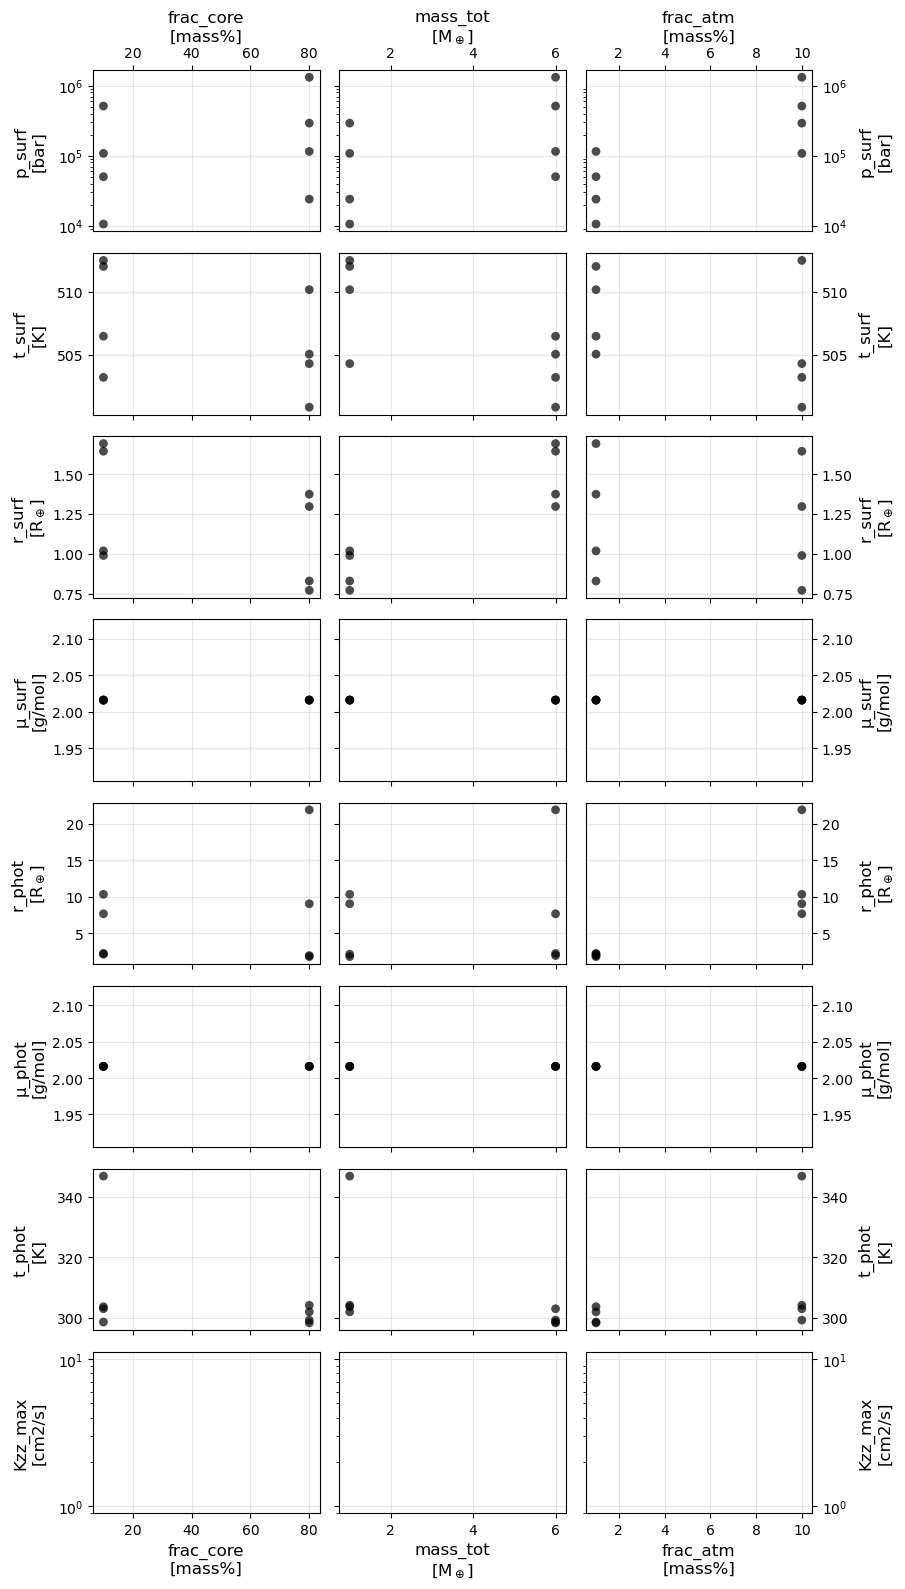

In [24]:

# Create figure with subplots
fig, axes = plt.subplots(len(output_vars), len(input_vars),
                        figsize=(3*len(input_vars), 2*len(output_vars)))

# If only one row or column, ensure axes is 2D
if len(output_vars) == 1:
    axes = axes.reshape(1, -1)
if len(input_vars) == 1:
    axes = axes.reshape(-1, 1)

# Plot each combination
for i, output_var in enumerate(output_vars):
    for j, input_var in enumerate(input_vars):
        ax = axes[i, j]

        x = np.array(data[input_var]) * units[input_var][0]
        xunit = units[input_var][2]
        if units[input_var][1]:
            ax.set_xscale("log")

        y = np.array(data[output_var]) * units[output_var][0]
        yunit = units[output_var][2]
        if units[output_var][1]:
            ax.set_yscale("log")

        # Create scatter plot
        scatter = ax.scatter(x,y, zorder=3, alpha=0.7, s=40,
                                edgecolor='none', linewidth=0.5, color='k')

        # Set labels and title
        if (i == len(output_vars)-1) or (i == 0):
            ax.set_xlabel(f"{input_var}\n[{xunit}]", fontsize=12)
            if i == 0:
                ax.xaxis.set_label_position('top')
                ax.xaxis.set_tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        else:
            ax.set_xticklabels([])

        if (j == len(input_vars)-1) or (j == 0):
            ax.set_ylabel(f"{output_var}\n[{yunit}]", fontsize=12)
            if (j == len(input_vars)-1):
                ax.yaxis.set_label_position('right')
                ax.yaxis.set_tick_params(right=True, labelright=True, left=False, labelleft=False)
        else:
            ax.set_yticklabels([])

        # Add grid
        ax.grid(True, alpha=0.3, zorder=-2)

        # Format axes
        ax.tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout()
fig.align_ylabels()
fig.align_xlabels()

# Save the plot
fig.savefig(os.path.join(output_dir, "matrix.pdf"), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

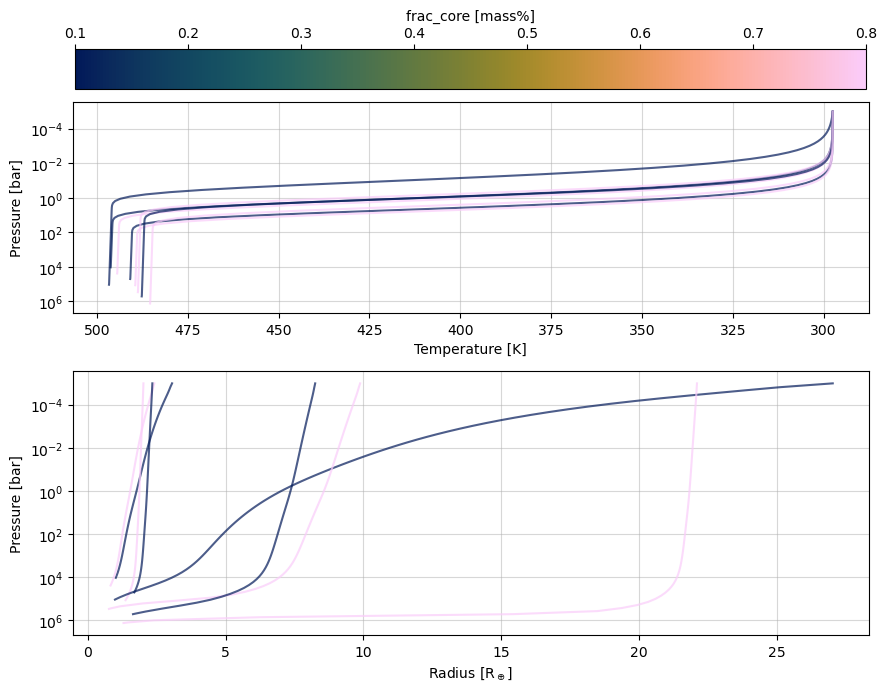

In [25]:
fig, axs = plt.subplots(2,1, figsize=(9,7))
(axt, axb) = axs

key = "frac_core"
norm = mpl.colors.Normalize(vmin=np.amin(data[key]), vmax=np.amax(data[key]))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=batlow)

al = 0.7
for i in range(gridsize):
    col = sm.to_rgba(data.iloc[i][key])
    axt.plot(data_t[i]        , data_p[i]/bar, zorder=2, color=col, alpha=al)
    axb.plot(data_r[i]/R_earth, data_p[i]/bar, zorder=2, color=col, alpha=al)

axt.invert_xaxis()
axt.set_xlabel("Temperature [K]")
axb.set_xlabel(r"Radius [R$_\oplus$]")

for ax in axs:
    ax.set_ylabel("Pressure [bar]")
    ax.set_yscale("log")
    ax.invert_yaxis()
    ax.grid(zorder=-2, alpha=0.5)

fig.colorbar(sm, ax=axt, label=f"{key} [{units[key][2]}]", location='top')

fig.tight_layout()
fig.align_ylabels()
fig.savefig(os.path.join(output_dir, "profiles.pdf"), dpi=300, bbox_inches='tight')
plt.show()